Plan: implement something simple for distributions

In [5]:
import jax.numpy as jnp
import jax.random as r

In [12]:
import jax

In [7]:
import optax

In [1]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

2024-10-17 12:24:02.232123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 12:24:02.287179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 12:24:02.292230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 12:24:11.255660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
jnp.e

2.718281828459045

In [ ]:
# create a jax pytree
{'loc': jnp.array([0.])}

In [9]:
orig_key = r.key(42)
target_dist = tfd.Normal(loc=jnp.pi, scale=jnp.e)

In [31]:
def compute_loss(params, x):
    dist = tfd.Normal(loc=params['loc'], scale=params['scale'])
    return -dist.log_prob(x).sum()

In [30]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

params = {'loc': jnp.array([0.]), 'scale': jnp.array([1.])}
opt_state = optimizer.init(params)

In [32]:
stored_params = []

for step in range(1000):
    step_key = r.fold_in(orig_key, step)
    x = target_dist.sample(100, seed=step_key)
    grads = jax.grad(compute_loss)(params, x)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if step % 20 == 0:
        print(f"Step {step}, loss {compute_loss(params, x)}")
        stored_params.append(params)

        

Step 0, loss 786.9296875
Step 20, loss 263.7456970214844
Step 40, loss 251.68441772460938
Step 60, loss 238.89013671875
Step 80, loss 240.34251403808594
Step 100, loss 244.19403076171875
Step 120, loss 239.61798095703125
Step 140, loss 249.40591430664062
Step 160, loss 242.76678466796875
Step 180, loss 237.11915588378906
Step 200, loss 235.81748962402344
Step 220, loss 234.55465698242188
Step 240, loss 246.8770751953125
Step 260, loss 242.30593872070312
Step 280, loss 246.57948303222656
Step 300, loss 241.73886108398438
Step 320, loss 242.850341796875
Step 340, loss 242.52850341796875
Step 360, loss 239.80052185058594
Step 380, loss 237.48056030273438
Step 400, loss 236.65724182128906
Step 420, loss 241.11883544921875
Step 440, loss 243.19850158691406
Step 460, loss 242.165771484375
Step 480, loss 249.33285522460938
Step 500, loss 244.31900024414062
Step 520, loss 242.55758666992188
Step 540, loss 240.73159790039062
Step 560, loss 245.7747802734375
Step 580, loss 236.03787231445312
Ste

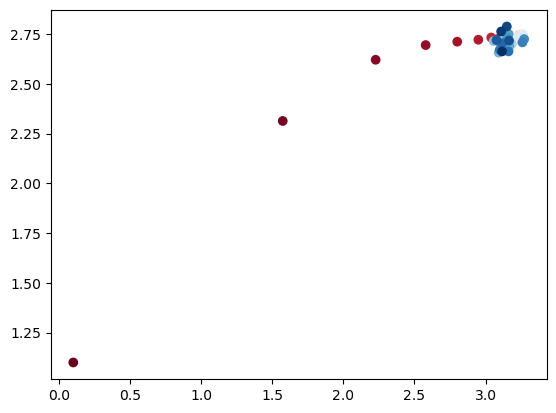

In [33]:
# plot the trajectory of the optimization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.RdBu(jnp.linspace(0, 1, len(stored_params)))
x = [store['loc'] for store in stored_params]
y = [store['scale'] for store in stored_params]
plt.scatter(x=x, y=y, color=colors)

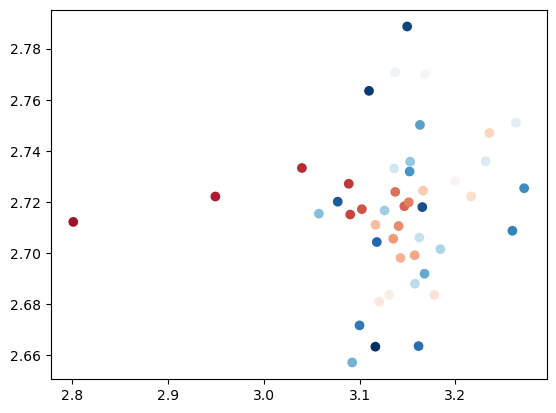

In [34]:
plt.scatter(x=x[4:], y=y[4:], color=colors[4:])

See that seem to hit some sort of plateau.  
Guess can improve by using a learning rate scheduler...

In [41]:
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=20,
    decay_rate=0.9
)

In [42]:
# Initialize the optimizer with the exponential scheduler
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0)
)

params = {'loc': jnp.array([0.]), 'scale': jnp.array([1.])}
opt_state = optimizer.init(params)
stored_params = []

for step in range(1000):
    step_key = r.fold_in(orig_key, step)
    x = target_dist.sample(100, seed=step_key)
    grads = jax.grad(compute_loss)(params, x)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if step % 20 == 0:
        print(f"Step {step}, loss {compute_loss(params, x)}")
        stored_params.append(params)

        

Step 0, loss 786.9296875
Step 20, loss 267.10174560546875
Step 40, loss 253.86373901367188
Step 60, loss 240.1229248046875
Step 80, loss 242.02957153320312
Step 100, loss 244.60995483398438
Step 120, loss 239.62567138671875
Step 140, loss 249.5343017578125
Step 160, loss 243.3884735107422
Step 180, loss 236.757568359375
Step 200, loss 235.68405151367188
Step 220, loss 234.75997924804688
Step 240, loss 247.05838012695312
Step 260, loss 242.33367919921875
Step 280, loss 246.57733154296875
Step 300, loss 241.82949829101562
Step 320, loss 242.82737731933594
Step 340, loss 242.5275115966797
Step 360, loss 239.66758728027344
Step 380, loss 237.1747589111328
Step 400, loss 237.06297302246094
Step 420, loss 241.06936645507812
Step 440, loss 243.2628173828125
Step 460, loss 242.13272094726562
Step 480, loss 249.5675811767578
Step 500, loss 244.35015869140625
Step 520, loss 242.48985290527344
Step 540, loss 241.11798095703125
Step 560, loss 245.73880004882812
Step 580, loss 236.11056518554688
St

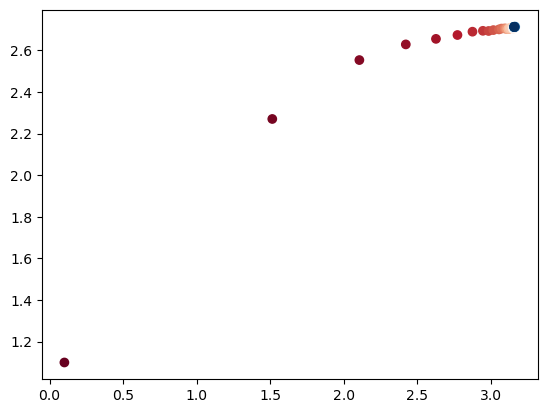

In [43]:
# plot the trajectory of the optimization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.RdBu(jnp.linspace(0, 1, len(stored_params)))
x = [store['loc'] for store in stored_params]
y = [store['scale'] for store in stored_params]
plt.scatter(x=x, y=y, color=colors)

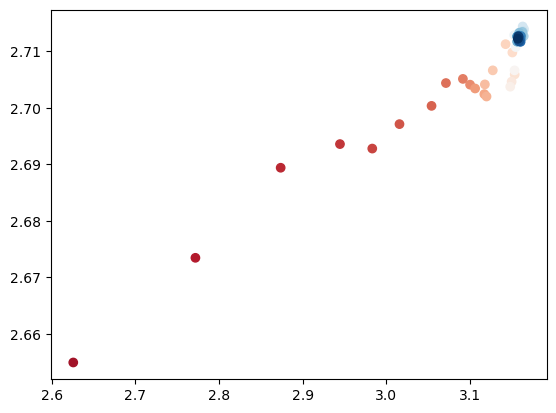

In [44]:
plt.scatter(x=x[4:], y=y[4:], color=colors[4:])